In [1]:
import cv2
import torch

import sys
sys.path.append("../")

from yolort.utils import cv2_imshow, get_image_from_url, read_image_to_tensor
from yolort.utils.image_utils import color_list, plot_one_box

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read an image

Let's request and pre-process the images that to be detected.

In [3]:
img_raw = get_image_from_url("https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/test/assets/bus.jpg")
# img_raw = cv2.imread('../test/assets/bus.jpg')
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
img = read_image_to_tensor(img)
img = img.to(device)

## Model Definition and Initialization

In [4]:
from yolort.models import yolov5s

In [5]:
model = yolov5s(upstream_version='r4.0', pretrained=True, score_thresh=0.25)

In [6]:
model.eval()
model = model.to(device)

In [7]:
# Perform inference on an image tensor
model_out = model.predict(img)

## Varify the PyTorch backend inference results

In [8]:
model_out[0]['boxes'].cpu().detach()

tensor([[5.3936e+01, 3.8969e+02, 2.3813e+02, 8.9804e+02],
        [2.2363e+02, 4.0916e+02, 3.4414e+02, 8.6141e+02],
        [1.8697e+01, 2.2583e+02, 8.0069e+02, 7.6132e+02],
        [6.7356e+02, 3.9818e+02, 8.1325e+02, 8.7141e+02],
        [4.6686e-01, 5.5049e+02, 6.6365e+01, 8.7987e+02]])

*Target outputs of boxes (yolov5s, with shape of 1080x810):*

```
tensor([[ 48.4041, 401.9219, 237.0266, 897.8111],
        [215.3344, 408.0325, 344.7906, 857.3686],
        [ 13.2764, 225.2432, 802.3018, 735.7723],
        [674.4550, 397.7541, 812.1368, 868.5444]])
```

In [9]:
model_out[0]['scores'].cpu().detach()

tensor([0.8760, 0.8728, 0.8249, 0.7947, 0.3525])

*Target outputs of scores: (`yolov5s`, with shape of 1080x810)*

```
tensor([0.8940, 0.8635, 0.8609, 0.7063])
```

In [10]:
model_out[0]['labels'].cpu().detach()

tensor([0, 0, 5, 0, 0])

*Target outputs of labels:*

```
tensor([0, 0, 5, 0])
```

## Detection output visualisation

First let get the labels of COCO datasets.

In [11]:
# Get label names
import requests

labels = []
response = requests.get("https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/notebooks/assets/coco.names")
names = response.text

for label in names.strip().split('\n'):
    labels.append(label)

The labels can also be obtained by

```python
from yolort.utils.image_utils load_names
labels = load_names('../notebooks/assets/coco.names')
```

In [12]:
colors = color_list()
for box, label in zip(model_out[0]['boxes'].tolist(), model_out[0]['labels'].tolist()):
    img_raw = plot_one_box(box, img_raw, color=colors[label % len(colors)], label=labels[label])

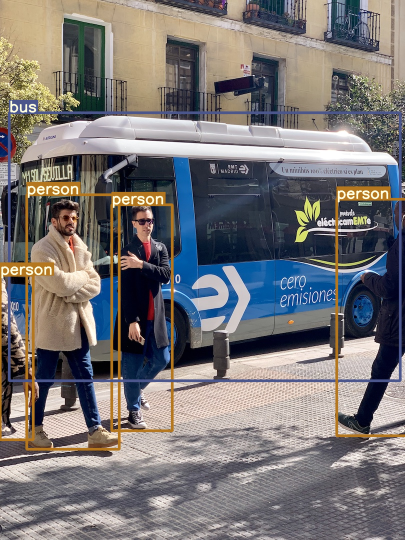

In [13]:
cv2_imshow(img_raw, imshow_scale=0.5)

## Scripting YOLOv5

In [14]:
# TorchScript export
print(f'Starting TorchScript export with torch {torch.__version__}...')
export_script_name = 'yolov5s.torchscript.pt'  # filename

Starting TorchScript export with torch 1.7.1...


In [15]:
model_script = torch.jit.script(model)
model_script.eval()
model_script = model_script.to(device)

In [16]:
# Save the scripted model file for subsequent use (Optional)
model_script.save(export_script_name)

## Inference on TorchScript Backend

In [17]:
x = [img]
out = model(x)
out_script = model_script(x)

..\yolort\models\yolo.py:121: UserWarning: YOLO always returns a (Losses, Detections) tuple in scripting.
  warnings.warn("YOLO always returns a (Losses, Detections) tuple in scripting.")
..\yolort\models\yolo_module.py:109: UserWarning: YOLOModule always returns Detections in scripting.
  warnings.warn("YOLOModule always returns Detections in scripting.")


## Varify the Inference Output on LibTorch backend

In [18]:
for k, v in out[0].items():
    torch.testing.assert_allclose(out_script[0][k], v, rtol=1e-07, atol=1e-09)

print("Exported model has been tested with libtorch, and the result looks good!")

Exported model has been tested with libtorch, and the result looks good!


### Comparing Inference Time between `pytorch` and `libtorch`

**Time consumed on PyTorch backend**

In [19]:
%%time
with torch.no_grad():
    out = model(x)

Wall time: 18 ms


**Time consumed on LibTorch backend**

In [20]:
# Dummy run once for torchscript
with torch.no_grad():
    out_script = model_script(x)

In [21]:
%%time
with torch.no_grad():
    out_script = model_script(x)

Wall time: 14.5 ms
